In [1]:
# source activate sg_bm
# conda activate sg_bm
import sys
sys.executable 

'/home/engineering/anaconda3/envs/sg_bm/bin/python'

In [1]:
import os
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
from graphviz import Digraph, Source

In [2]:
ag_data_root = '/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/'

image_path = os.path.join(ag_data_root, 'frames')
vocab_file = json.load(open(ag_data_root + 'annotations/COCO/AG-SGG-test.json'))
data_file = json.load(open(ag_data_root + "annotations/COCO/AG_test.json"))

In [3]:
# load detected results
detected_origin_path = '/home/engineering/Documents/Thesis/Scene-Graph-Benchmark.pytorch/output/Saved_models/RL=Transformer_v2/inference/AG_v3Graph_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [4]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    print(img_path)
    # boxes
    boxes = groundtruth.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [5]:
def graph_viz(name, all_ids, rels):
    G = Digraph(comment='Action Genome: {}'.format(name), node_attr={'color': 'lightblue2', 'style': 'filled', 'fontsize': '30'})
    # G.attr(size='1000,1000!')
    G.node('Person', shape='doublecircle')
    for t in range(len(rels)):
        G.edge('Person', 't{}'.format(t+1))
        G.attr('node', shape='doublecircle', ranksep = '10000')
        relations = rels[t]
        for i in range(len(relations)):
            G.edge('t{}'.format(t), relations[i][2].split('-')[-1], relations[i][1].split('-')[-1], ranksep='10000000')
    print(G)
    dot = Source(G)
    dot.format = 'png'
    dot.render(name, view=True)

In [6]:
def get_ids(name):
    idx = 0
    all_ids = []; gts=[]; preds=[]
    while idx < len(detected_info):
        img_path = detected_info[idx]['img_file']
        if img_path.split('/')[-2] == name:
            img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label = get_info_by_idx(idx, detected_origin_result, thres=0.5)
            gts.append(gt_rels)
            preds.append(pred_rels)
            all_ids.append(idx)
        idx += 1
    return all_ids, gts, preds

In [7]:
def clean_graph(gt_rels, pred_rels):
    final_pred_rels = []
    all_objs = []; all_rels = []

    idx_to_predicate = {
        "attention": ["looking_at", "not_looking_at", "unsure"],
        "spatial": ["above", "beneath", "in_front_of", "behind", "on_the_side_of", "in"],
        "contact": ["carrying","covered_by","drinking_from","eating","have_it_on_the_back","holding","leaning_on","lying_on","not_contacting","other_relationship",                         "sitting_on","standing_on","touching","twisting","wearing","wiping","writing_on"]}

    for idx, pred in enumerate(pred_rels):
        objs = list(set(triplets[2] for triplets in pred))
        rels = list(set(triplets[1] for triplets in pred))
        if len(all_objs) > 1:
            if all_objs[-1] == objs:
                if all_rels[-1] == rels:
                    continue
            else:
                for relationship in idx_to_predicate.keys():
                    rel_count = 0; sit_count = 0; stand_count = 0
                    for triplet in pred:
                        if triplet[1] in idx_to_predicate[relationship]:
                            rel_count += 1
                            if rel_count > len(objs):
                                pred.remove(triplet)
                        
                        if relationship == 'attention': # Only to be run once
                            if any(item in ['other_relationship', 'unsure'] for item in triplet):
                                pred.remove(triplet)
                        
                            if triplet[1] == 'standing':
                                if sit_count > 1:
                                    pred.remove(triplet)
                                stand_count += 1
                            elif triplet[1] == 'sitting':
                                if sit_count > 1:
                                    pred.remove(triplet)
                                sit_count += 1
    
                final_pred_rels.append(pred)
        else:
            final_pred_rels.append(pred)
        all_objs.append(objs)
        all_rels.append(rels)
    return final_pred_rels

# all_ids, gt_rels, pred_rels = get_ids(name)
# print(pred_rels)
# clean_graph(gt_rels, pred_rels)

In [158]:
name = 'MSACP.mp4'
all_ids, gt_rels, pred_rels = get_ids(name)
pred_rels = clean_graph(gt_rels, pred_rels)
graph_viz(name, all_ids, pred_rels)
# show_selected(all_ids)

/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000345.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000009.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000026.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000043.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000076.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000085.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000029.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000059.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000091.png
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000197.png
/media/engineering/Millenium Falcon/Thesis/ActionG

In [8]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None

In [9]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))

0
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MLWB5.mp4/000714.png


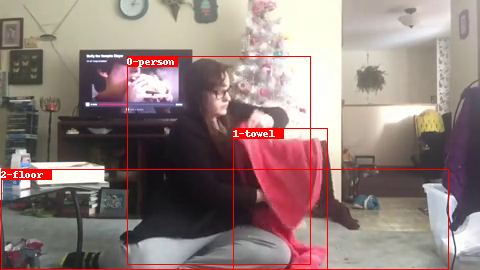

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-towel
gt_boxes 2: 2-floor
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-towel')
gt_rels 1: ('0-person', 'in_front_of', '1-towel')
gt_rels 2: ('0-person', 'holding', '1-towel')
gt_rels 3: ('0-person', 'not_looking_at', '2-floor')
gt_rels 4: ('0-person', 'beneath', '2-floor')
gt_rels 5: ('0-person', 'sitting_on', '2-floor')
**************************************************
pred_rels 0: ('2-person', 'in', '4-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'on_the_side_of', '234-person')
pred_rels 3: ('1-person', 'unsure', '235-person')
pred_rels 4: ('1-person', 'on_the_side_of', '236-person')
pred_rels 5: ('1-person', 'on_the_side_of', '237-person')
pred_rels 6: ('1-person', 'unsure', '238-person')
pred_rels 7: ('2-person', 'in', '1-person')
pred_rels 8: ('2-person', 'writing_on', '2-person')
pred_rels 9: ('2-person', '

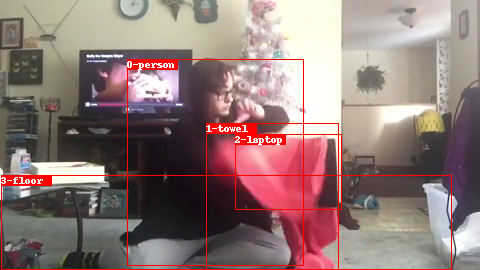

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-towel
gt_boxes 2: 2-laptop
gt_boxes 3: 3-floor
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-towel')
gt_rels 1: ('0-person', 'in_front_of', '1-towel')
gt_rels 2: ('0-person', 'holding', '1-towel')
gt_rels 3: ('0-person', 'looking_at', '2-laptop')
gt_rels 4: ('0-person', 'in_front_of', '2-laptop')
gt_rels 5: ('0-person', 'holding', '2-laptop')
gt_rels 6: ('0-person', 'not_looking_at', '3-floor')
gt_rels 7: ('0-person', 'beneath', '3-floor')
gt_rels 8: ('0-person', 'sitting_on', '3-floor')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'in', '5-person')
pred_rels 2: ('1-person', 'in_front_of', '235-bag')
pred_rels 3: ('1-person', 'on_the_side_of', '236-person')
pred_rels 4: ('1-person', 'unsure', '237-person')
pred_rels 5: ('1-person', 'on_the_side_of', '238-person')
pred_r

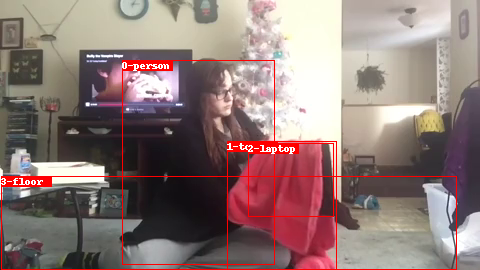

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-towel
gt_boxes 2: 2-laptop
gt_boxes 3: 3-floor
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-towel')
gt_rels 1: ('0-person', 'in_front_of', '1-towel')
gt_rels 2: ('0-person', 'holding', '1-towel')
gt_rels 3: ('0-person', 'looking_at', '2-laptop')
gt_rels 4: ('0-person', 'in_front_of', '2-laptop')
gt_rels 5: ('0-person', 'holding', '2-laptop')
gt_rels 6: ('0-person', 'not_looking_at', '3-floor')
gt_rels 7: ('0-person', 'beneath', '3-floor')
gt_rels 8: ('0-person', 'sitting_on', '3-floor')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '5-person')
pred_rels 1: ('2-person', 'in', '6-person')
pred_rels 2: ('1-person', 'on_the_side_of', '237-person')
pred_rels 3: ('1-person', 'on_the_side_of', '238-person')
pred_rels 4: ('1-person', 'unsure', '239-bag')
pred_rels 5: ('1-person', 'on_the_side_of', '240-person')
pred_re

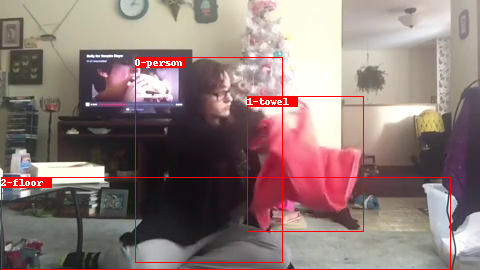

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-towel
gt_boxes 2: 2-floor
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-towel')
gt_rels 1: ('0-person', 'in_front_of', '1-towel')
gt_rels 2: ('0-person', 'covered_by', '1-towel')
gt_rels 3: ('0-person', 'not_looking_at', '2-floor')
gt_rels 4: ('0-person', 'beneath', '2-floor')
gt_rels 5: ('0-person', 'sitting_on', '2-floor')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'on_the_side_of', '216-person')
pred_rels 3: ('1-person', 'on_the_side_of', '217-person')
pred_rels 4: ('1-person', 'unsure', '218-person')
pred_rels 5: ('1-person', 'in_front_of', '219-bag')
pred_rels 6: ('2-person', 'writing_on', '1-person')
pred_rels 7: ('2-person', 'writing_on', '2-person')
pred_rels 8: ('2-person', 'in', '3-person')
pred_rels 9: ('1-per

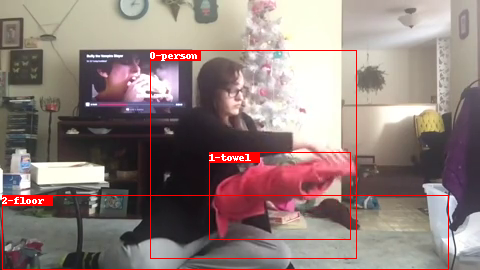

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-towel
gt_boxes 2: 2-floor
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-towel')
gt_rels 1: ('0-person', 'in_front_of', '1-towel')
gt_rels 2: ('0-person', 'holding', '1-towel')
gt_rels 3: ('0-person', 'not_looking_at', '2-floor')
gt_rels 4: ('0-person', 'beneath', '2-floor')
gt_rels 5: ('0-person', 'sitting_on', '2-floor')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'in', '5-person')
pred_rels 2: ('1-person', 'on_the_side_of', '235-person')
pred_rels 3: ('1-person', 'on_the_side_of', '236-person')
pred_rels 4: ('1-person', 'unsure', '237-person')
pred_rels 5: ('1-person', 'on_the_side_of', '238-person')
pred_rels 6: ('1-person', 'on_the_side_of', '239-person')
pred_rels 7: ('2-person', 'writing_on', '1-person')
pred_rels 8: ('2-person', 'in', '2-person')
pred_rels 9: ('2-pe

In [10]:
show_all(start_idx=0, length=5)

24
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MMFQA.mp4/000036.png


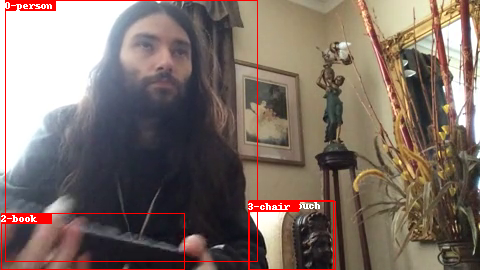

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-sofa/couch
gt_boxes 2: 2-book
gt_boxes 3: 3-chair
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-sofa/couch')
gt_rels 1: ('0-person', 'beneath', '1-sofa/couch')
gt_rels 2: ('0-person', 'sitting_on', '1-sofa/couch')
gt_rels 3: ('0-person', 'not_looking_at', '2-book')
gt_rels 4: ('0-person', 'in_front_of', '2-book')
gt_rels 5: ('0-person', 'holding', '2-book')
gt_rels 6: ('0-person', 'not_looking_at', '3-chair')
gt_rels 7: ('0-person', 'beneath', '3-chair')
gt_rels 8: ('0-person', 'sitting_on', '3-chair')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'in_front_of', '156-bag')
pred_rels 3: ('2-person', 'writing_on', '1-person')
pred_rels 4: ('2-person', 'writing_on', '2-person')
pred_rels 5: ('2-person', 'in', '3-person')
p

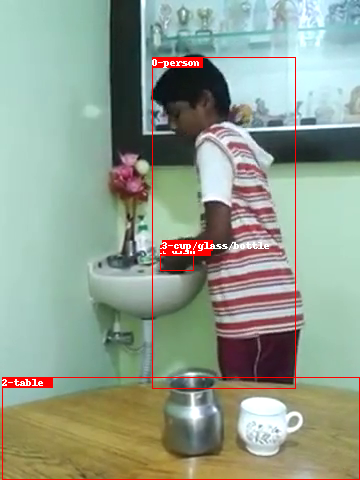

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-dish
gt_boxes 2: 2-table
gt_boxes 3: 3-cup/glass/bottle
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-dish')
gt_rels 1: ('0-person', 'in_front_of', '1-dish')
gt_rels 2: ('0-person', 'holding', '1-dish')
gt_rels 3: ('0-person', 'not_looking_at', '2-table')
gt_rels 4: ('0-person', 'on_the_side_of', '2-table')
gt_rels 5: ('0-person', 'not_contacting', '2-table')
gt_rels 6: ('0-person', 'looking_at', '3-cup/glass/bottle')
gt_rels 7: ('0-person', 'in_front_of', '3-cup/glass/bottle')
gt_rels 8: ('0-person', 'holding', '3-cup/glass/bottle')
**************************************************
pred_rels 0: ('1-person', 'on_the_side_of', '258-person')
pred_rels 1: ('1-person', 'in_front_of', '257-bag')
pred_rels 2: ('2-person', 'writing_on', '2-person')
pred_rels 3: ('2-person', 'in', '1-person')
pred_rels 4: ('1-person', 'unsure', '259-person')
pred_rels 5: ('2-pers

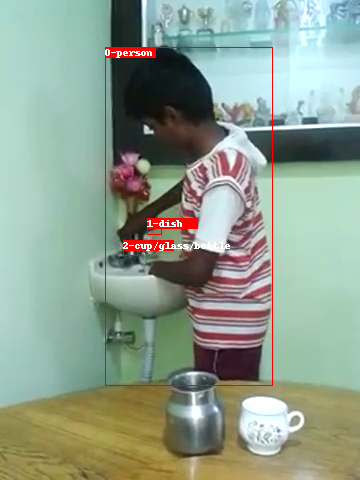

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-dish
gt_boxes 2: 2-cup/glass/bottle
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-dish')
gt_rels 1: ('0-person', 'in_front_of', '1-dish')
gt_rels 2: ('0-person', 'holding', '1-dish')
gt_rels 3: ('0-person', 'looking_at', '2-cup/glass/bottle')
gt_rels 4: ('0-person', 'in_front_of', '2-cup/glass/bottle')
gt_rels 5: ('0-person', 'holding', '2-cup/glass/bottle')
**************************************************
pred_rels 0: ('1-person', 'on_the_side_of', '264-person')
pred_rels 1: ('1-person', 'unsure', '263-person')
pred_rels 2: ('2-person', 'in', '3-person')
pred_rels 3: ('2-person', 'writing_on', '2-person')
pred_rels 4: ('2-person', 'writing_on', '1-person')
pred_rels 5: ('2-person', 'writing_on', '5-person')
pred_rels 6: ('2-person', 'in', '6-person')
pred_rels 7: ('1-person', 'on_the_side_of', '262-person')
pred_rels 8: ('1-person', 'on_the_side_of', '2

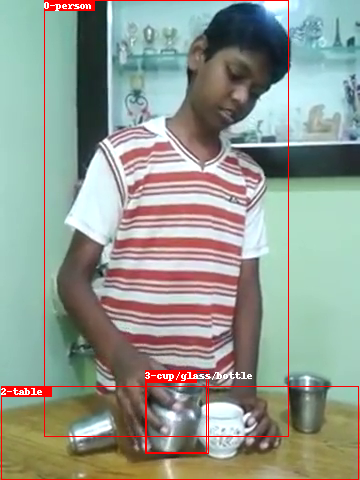

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-dish
gt_boxes 2: 2-table
gt_boxes 3: 3-cup/glass/bottle
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-dish')
gt_rels 1: ('0-person', 'in_front_of', '1-dish')
gt_rels 2: ('0-person', 'holding', '1-dish')
gt_rels 3: ('0-person', 'not_looking_at', '2-table')
gt_rels 4: ('0-person', 'in_front_of', '2-table')
gt_rels 5: ('0-person', 'not_contacting', '2-table')
gt_rels 6: ('0-person', 'looking_at', '3-cup/glass/bottle')
gt_rels 7: ('0-person', 'in_front_of', '3-cup/glass/bottle')
gt_rels 8: ('0-person', 'holding', '3-cup/glass/bottle')
**************************************************
pred_rels 0: ('1-person', 'unsure', '265-person')
pred_rels 1: ('1-person', 'on_the_side_of', '264-person')
pred_rels 2: ('2-person', 'writing_on', '3-person')
pred_rels 3: ('2-person', 'writing_on', '2-person')
pred_rels 4: ('2-person', 'in', '1-person')
pred_rels 5: ('2-person'

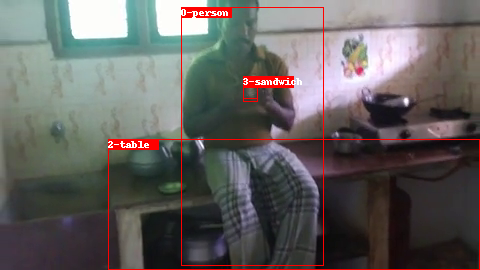

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-food
gt_boxes 2: 2-table
gt_boxes 3: 3-sandwich
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-food')
gt_rels 1: ('0-person', 'in_front_of', '1-food')
gt_rels 2: ('0-person', 'holding', '1-food')
gt_rels 3: ('0-person', 'not_looking_at', '2-table')
gt_rels 4: ('0-person', 'in_front_of', '2-table')
gt_rels 5: ('0-person', 'touching', '2-table')
gt_rels 6: ('0-person', 'looking_at', '3-sandwich')
gt_rels 7: ('0-person', 'in_front_of', '3-sandwich')
gt_rels 8: ('0-person', 'eating', '3-sandwich')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '3-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'unsure', '202-person')
pred_rels 3: ('1-person', 'on_the_side_of', '203-person')
pred_rels 4: ('1-person', 'on_the_side_of', '204-person')
pred_rels 5: ('1-person', 'unsure', '205-person')

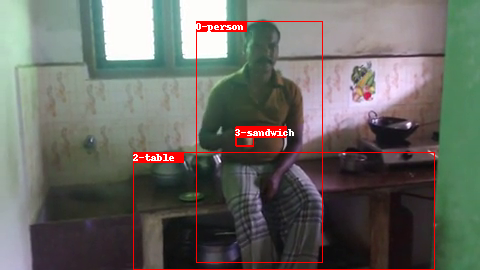

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-food
gt_boxes 2: 2-table
gt_boxes 3: 3-sandwich
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-food')
gt_rels 1: ('0-person', 'in_front_of', '1-food')
gt_rels 2: ('0-person', 'holding', '1-food')
gt_rels 3: ('0-person', 'not_looking_at', '2-table')
gt_rels 4: ('0-person', 'beneath', '2-table')
gt_rels 5: ('0-person', 'sitting_on', '2-table')
gt_rels 6: ('0-person', 'not_looking_at', '3-sandwich')
gt_rels 7: ('0-person', 'in_front_of', '3-sandwich')
gt_rels 8: ('0-person', 'holding', '3-sandwich')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'unsure', '176-person')
pred_rels 3: ('1-person', 'on_the_side_of', '177-person')
pred_rels 4: ('2-person', 'writing_on', '1-person')
pred_rels 5: ('2-person', 'writing_on', '2-perso

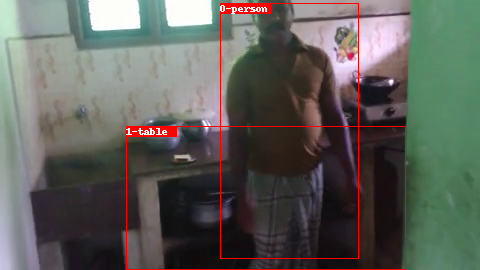

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-table
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-table')
gt_rels 1: ('0-person', 'behind', '1-table')
gt_rels 2: ('0-person', 'not_contacting', '1-table')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '3-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'on_the_side_of', '159-person')
pred_rels 3: ('1-person', 'unsure', '160-person')
pred_rels 4: ('2-person', 'in', '1-person')
pred_rels 5: ('2-person', 'writing_on', '2-person')
pred_rels 6: ('1-person', 'unsure', '157-person')
pred_rels 7: ('2-person', 'in', '4-person')
pred_rels 8: ('1-person', 'on_the_side_of', '156-person')
pred_rels 9: ('2-person', 'writing_on', '6-person')
pred_rels 10: ('2-person', 'in', '7-person')
pred_rels 11: ('2-person', 'writing_on', '8-person')
pred_rels 12: ('2-person', 'writing_on', '9-p

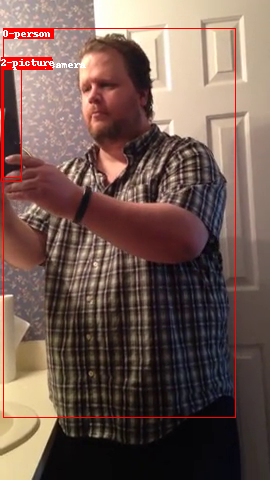

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-phone/camera
gt_boxes 2: 2-picture
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-phone/camera')
gt_rels 1: ('0-person', 'in_front_of', '1-phone/camera')
gt_rels 2: ('0-person', 'holding', '1-phone/camera')
gt_rels 3: ('0-person', 'looking_at', '2-picture')
gt_rels 4: ('0-person', 'in_front_of', '2-picture')
gt_rels 5: ('0-person', 'holding', '2-picture')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'writing_on', '6-person')
pred_rels 2: ('1-person', 'on_the_side_of', '227-person')
pred_rels 3: ('1-person', 'unsure', '228-bag')
pred_rels 4: ('1-person', 'on_the_side_of', '229-person')
pred_rels 5: ('1-person', 'on_the_side_of', '230-person')
pred_rels 6: ('2-person', 'writing_on', '1-person')
pred_rels 7: ('2-person', 'in', '2-person')
pred_rels 8: ('2-person', 'writing_on',

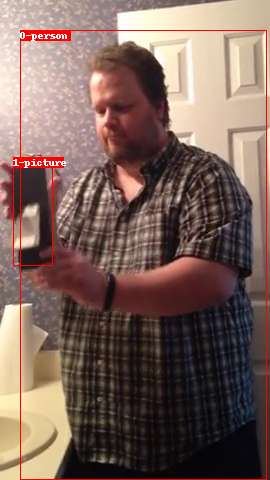

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-picture
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-picture')
gt_rels 1: ('0-person', 'in_front_of', '1-picture')
gt_rels 2: ('0-person', 'holding', '1-picture')
**************************************************
pred_rels 0: ('1-person', 'on_the_side_of', '258-person')
pred_rels 1: ('1-person', 'unsure', '257-person')
pred_rels 2: ('2-person', 'in', '3-person')
pred_rels 3: ('2-person', 'writing_on', '2-person')
pred_rels 4: ('2-person', 'writing_on', '1-person')
pred_rels 5: ('2-person', 'writing_on', '5-person')
pred_rels 6: ('2-person', 'in', '6-person')
pred_rels 7: ('1-person', 'on_the_side_of', '256-person')
pred_rels 8: ('1-person', 'on_the_side_of', '255-person')
pred_rels 9: ('1-person', 'unsure', '254-person')
pred_rels 10: ('2-person', 'writing_on', '4-person')
pred_rels 11: ('1-person', 'on_the_side_of', '252-person')
pred_rels 12: ('2-perso

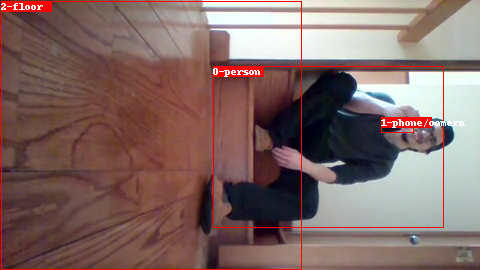

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-phone/camera
gt_boxes 2: 2-floor
**************************************************
gt_rels 0: ('0-person', 'looking_at', '1-phone/camera')
gt_rels 1: ('0-person', 'in_front_of', '1-phone/camera')
gt_rels 2: ('0-person', 'holding', '1-phone/camera')
gt_rels 3: ('0-person', 'not_looking_at', '2-floor')
gt_rels 4: ('0-person', 'beneath', '2-floor')
gt_rels 5: ('0-person', 'sitting_on', '2-floor')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '3-person')
pred_rels 1: ('2-person', 'in', '5-person')
pred_rels 2: ('1-person', 'unsure', '183-person')
pred_rels 3: ('1-person', 'on_the_side_of', '184-person')
pred_rels 4: ('1-person', 'on_the_side_of', '185-person')
pred_rels 5: ('2-person', 'writing_on', '1-person')
pred_rels 6: ('2-person', 'in', '2-person')
pred_rels 7: ('1-person', 'on_the_side_of', '181-person')
pred_rels 8: ('2-person', 'writing_on', '4-person

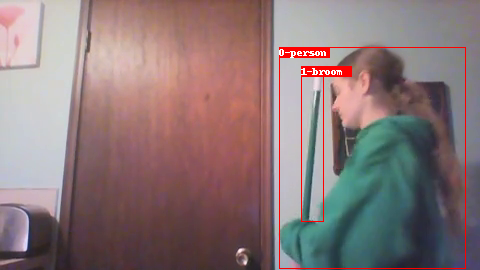

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-broom
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-broom')
gt_rels 1: ('0-person', 'in_front_of', '1-broom')
gt_rels 2: ('0-person', 'holding', '1-broom')
**************************************************
pred_rels 0: ('2-person', 'writing_on', '4-person')
pred_rels 1: ('2-person', 'writing_on', '5-person')
pred_rels 2: ('1-person', 'on_the_side_of', '156-person')
pred_rels 3: ('2-person', 'writing_on', '1-person')
pred_rels 4: ('2-person', 'writing_on', '2-person')
pred_rels 5: ('2-person', 'in', '3-person')
pred_rels 6: ('1-person', 'on_the_side_of', '154-person')
pred_rels 7: ('1-person', 'unsure', '152-person')
pred_rels 8: ('2-person', 'in', '6-person')
pred_rels 9: ('2-person', 'writing_on', '7-person')
pred_rels 10: ('2-person', 'writing_on', '8-person')
pred_rels 11: ('2-person', 'in', '9-person')
pred_rels 12: ('1-person', 'unsure', '155-per

In [11]:
show_selected([24, 56, 74, 92, 107, 127, 139, 146, 155, 183, 200])

244
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MSACP.mp4/000404.png


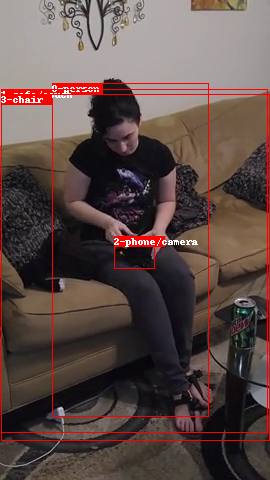

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-sofa/couch
gt_boxes 2: 2-phone/camera
gt_boxes 3: 3-chair
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-sofa/couch')
gt_rels 1: ('0-person', 'beneath', '1-sofa/couch')
gt_rels 2: ('0-person', 'sitting_on', '1-sofa/couch')
gt_rels 3: ('0-person', 'looking_at', '2-phone/camera')
gt_rels 4: ('0-person', 'in_front_of', '2-phone/camera')
gt_rels 5: ('0-person', 'holding', '2-phone/camera')
gt_rels 6: ('0-person', 'not_looking_at', '3-chair')
gt_rels 7: ('0-person', 'beneath', '3-chair')
gt_rels 8: ('0-person', 'sitting_on', '3-chair')
**************************************************
pred_rels 0: ('0-person', 'looking_at', '1-sofa/couch')
pred_rels 1: ('0-person', 'on_the_side_of', '2-phone/camera')
pred_rels 2: ('0-person', 'in', '3-chair')
pred_rels 3: ('0-person', 'beneath', '3-chair')
pred_rels 4: ('0-person', 'holding', '2-phone/camera')
pred_rels 5: 

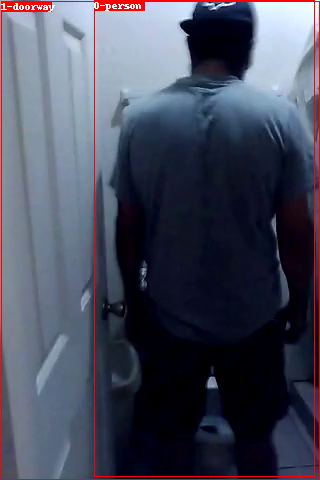

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-doorway
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-doorway')
gt_rels 1: ('0-person', 'in', '1-doorway')
gt_rels 2: ('0-person', 'not_contacting', '1-doorway')
**************************************************
pred_rels 0: ('0-person', 'behind', '1-doorway')
pred_rels 1: ('0-person', 'in', '1-doorway')
pred_rels 2: ('0-person', 'not_looking_at', '1-doorway')
**************************************************
392
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MUQBW.mp4/000641.png


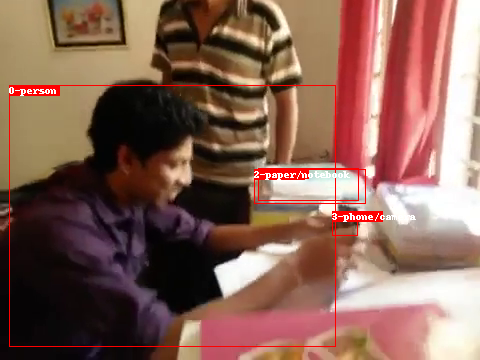

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-book
gt_boxes 2: 2-paper/notebook
gt_boxes 3: 3-phone/camera
**************************************************
gt_rels 0: ('0-person', 'unsure', '1-book')
gt_rels 1: ('0-person', 'in_front_of', '1-book')
gt_rels 2: ('0-person', 'not_contacting', '1-book')
gt_rels 3: ('0-person', 'not_looking_at', '2-paper/notebook')
gt_rels 4: ('0-person', 'on_the_side_of', '2-paper/notebook')
gt_rels 5: ('0-person', 'not_contacting', '2-paper/notebook')
gt_rels 6: ('0-person', 'looking_at', '3-phone/camera')
gt_rels 7: ('0-person', 'in_front_of', '3-phone/camera')
gt_rels 8: ('0-person', 'holding', '3-phone/camera')
**************************************************
pred_rels 0: ('0-person', 'looking_at', '1-book')
pred_rels 1: ('0-person', 'unsure', '2-paper/notebook')
pred_rels 2: ('0-person', 'other_relationship', '3-phone/camera')
pred_rels 3: ('0-person', 'in_front_of', '1-book')
pred_rels 4: ('0-person', 'in_f

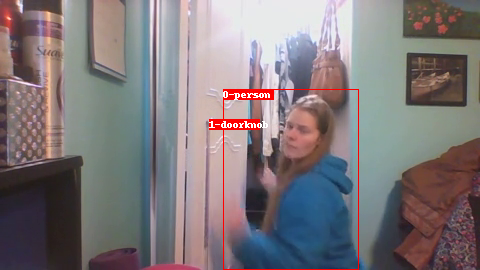

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-doorknob
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-doorknob')
gt_rels 1: ('0-person', 'in_front_of', '1-doorknob')
gt_rels 2: ('0-person', 'not_contacting', '1-doorknob')
**************************************************
pred_rels 0: ('0-person', 'in_front_of', '1-doorknob')
pred_rels 1: ('0-person', 'drinking_from', '1-doorknob')
pred_rels 2: ('0-person', 'writing_on', '1-doorknob')
**************************************************
521
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MXATD.mp4/000176.png


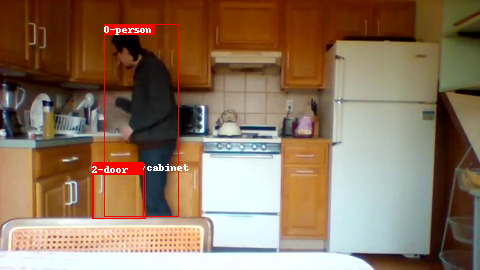

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-closet/cabinet
gt_boxes 2: 2-door
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-closet/cabinet')
gt_rels 1: ('0-person', 'in_front_of', '1-closet/cabinet')
gt_rels 2: ('0-person', 'not_contacting', '1-closet/cabinet')
gt_rels 3: ('0-person', 'not_looking_at', '2-door')
gt_rels 4: ('0-person', 'in_front_of', '2-door')
gt_rels 5: ('0-person', 'not_contacting', '2-door')
**************************************************
pred_rels 0: ('0-person', 'drinking_from', '2-door')
pred_rels 1: ('0-person', 'in_front_of', '1-closet/cabinet')
pred_rels 2: ('0-person', 'not_contacting', '1-closet/cabinet')
pred_rels 3: ('0-person', 'in_front_of', '2-door')
pred_rels 4: ('0-person', 'not_looking_at', '2-door')
pred_rels 5: ('0-person', 'writing_on', '1-closet/cabinet')
**************************************************
601
/media/engineering/Millenium Falcon/Thesis/A

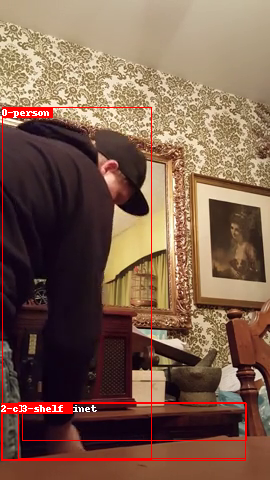

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-table
gt_boxes 2: 2-closet/cabinet
gt_boxes 3: 3-shelf
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-table')
gt_rels 1: ('0-person', 'on_the_side_of', '1-table')
gt_rels 2: ('0-person', 'not_contacting', '1-table')
gt_rels 3: ('0-person', 'looking_at', '2-closet/cabinet')
gt_rels 4: ('0-person', 'in_front_of', '2-closet/cabinet')
gt_rels 5: ('0-person', 'holding', '2-closet/cabinet')
gt_rels 6: ('0-person', 'unsure', '3-shelf')
gt_rels 7: ('0-person', 'in_front_of', '3-shelf')
gt_rels 8: ('0-person', 'not_contacting', '3-shelf')
**************************************************
pred_rels 0: ('0-person', 'looking_at', '1-table')
pred_rels 1: ('0-person', 'unsure', '2-closet/cabinet')
pred_rels 2: ('0-person', 'other_relationship', '3-shelf')
pred_rels 3: ('0-person', 'not_contacting', '1-table')
pred_rels 4: ('0-person', 'in_front_of', '1-table')
pred_

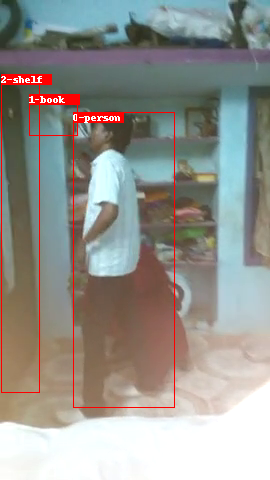

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-book
gt_boxes 2: 2-shelf
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-book')
gt_rels 1: ('0-person', 'beneath', '1-book')
gt_rels 2: ('0-person', 'holding', '1-book')
gt_rels 3: ('0-person', 'not_looking_at', '2-shelf')
gt_rels 4: ('0-person', 'in_front_of', '2-shelf')
gt_rels 5: ('0-person', 'not_contacting', '2-shelf')
**************************************************
pred_rels 0: ('0-person', 'in_front_of', '1-book')
pred_rels 1: ('0-person', 'not_contacting', '2-shelf')
pred_rels 2: ('0-person', 'in_front_of', '2-shelf')
pred_rels 3: ('0-person', 'holding', '1-book')
pred_rels 4: ('0-person', 'not_looking_at', '2-shelf')
pred_rels 5: ('0-person', 'writing_on', '1-book')
**************************************************
856
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/MIAE4.mp4/000714.png


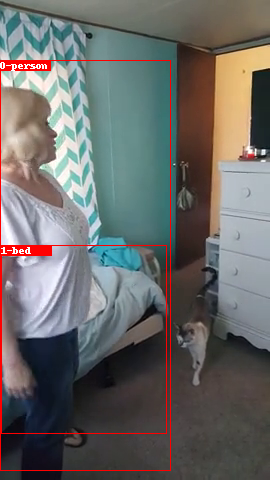

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-bed
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-bed')
gt_rels 1: ('0-person', 'behind', '1-bed')
gt_rels 2: ('0-person', 'not_contacting', '1-bed')
**************************************************
pred_rels 0: ('0-person', 'not_looking_at', '1-bed')
pred_rels 1: ('0-person', 'unsure', '1-bed')
pred_rels 2: ('0-person', 'wearing', '1-bed')
**************************************************
999
/media/engineering/Millenium Falcon/Thesis/ActionGenome/dataset/ag/frames/N0NLE.mp4/000866.png


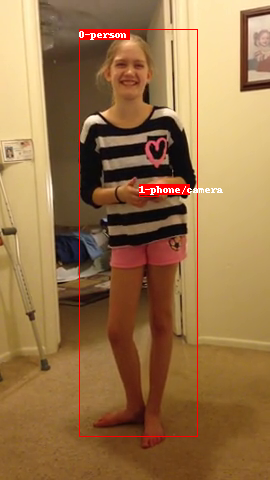

**************************************************
gt_boxes 0: 0-person
gt_boxes 1: 1-phone/camera
**************************************************
gt_rels 0: ('0-person', 'not_looking_at', '1-phone/camera')
gt_rels 1: ('0-person', 'in_front_of', '1-phone/camera')
gt_rels 2: ('0-person', 'holding', '1-phone/camera')
**************************************************
pred_rels 0: ('0-person', 'looking_at', '1-phone/camera')
pred_rels 1: ('0-person', 'above', '1-phone/camera')
pred_rels 2: ('0-person', 'drinking_from', '1-phone/camera')
**************************************************


In [12]:
show_selected([244, 369, 392, 450, 521, 601, 725, 856, 999])